ROADMAP

1. Resumo descritivo
    - Estatísticas descritivas (média, mediana, desvio-padrão, mínimo/máximo) para cada variável.
    - Separar os resumos por grupos do target.

2. Testes de normalidade
    - Aplicar Shapiro-Wilk, Kolmogorov-Smirnov ou QQ plots para verificar se variáveis seguem distribuição normal — isso orienta os testes posteriores.

3. Testes de hipóteses
    - T-test (ou Mann-Whitney U, se não-normal) para verificar se há diferença significativa nos grupos (ex: sono de fumantes vs. não-fumantes).
    - ANOVA (ou Kruskal-Wallis) para variáveis com mais de dois grupos (ex: Exercise frequency se categorizada).
    - Qui-quadrado para verificar independência entre variáveis categóricas (ex: Gender_encoded e Smoking_encoded).

4. Regressões
    - Regressão linear: usar Sleep efficiency como variável dependente e testar relações com Age, Sleep duration, Caffeine, etc.
    - Avaliar coeficientes, valores-p, R².
    - Considerar regressão múltipla com mais de uma variável preditora.

5. Análise de resíduos
    - Verificar suposições da regressão (homocedasticidade, normalidade dos resíduos, independência).
    - Plot dos resíduos vs. valores ajustados.
    - Histogramas e QQ-plots dos resíduos.

6. Multicolinearidade
    - Calcular VIF (Variance Inflation Factor) para verificar redundância entre variáveis preditoras nas regressões.

7. Discussão dos resultados
    - Quais hipóteses foram rejeitadas?
    - Quais variáveis mais influenciam o sono segundo as análises?
    - Alguma limitação observada?

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
from sleep_health.config import DATA_DIR

# Statistical Analysis
This notebook aims to explore the dataset through probability and statistical methods. The goal is to describe the data, assess relationships between variables, and draw inferences using descriptive statistics, hypothesis testing, regression analysis, and residual diagnostics.

## Descriptive summary

In [3]:
df = pd.read_csv(DATA_DIR / 'processed' / 'processed_data.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 452 entries, 0 to 451
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    452 non-null    int64  
 1   Age                   452 non-null    int64  
 2   Sleep duration        452 non-null    float64
 3   Sleep efficiency      452 non-null    float64
 4   Caffeine consumption  452 non-null    float64
 5   Alcohol consumption   452 non-null    float64
 6   Exercise frequency    452 non-null    float64
 7   Bedtime_hour          452 non-null    int64  
 8   Gender_encoded        452 non-null    int64  
 9   Smoking_encoded       452 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 38.8 KB


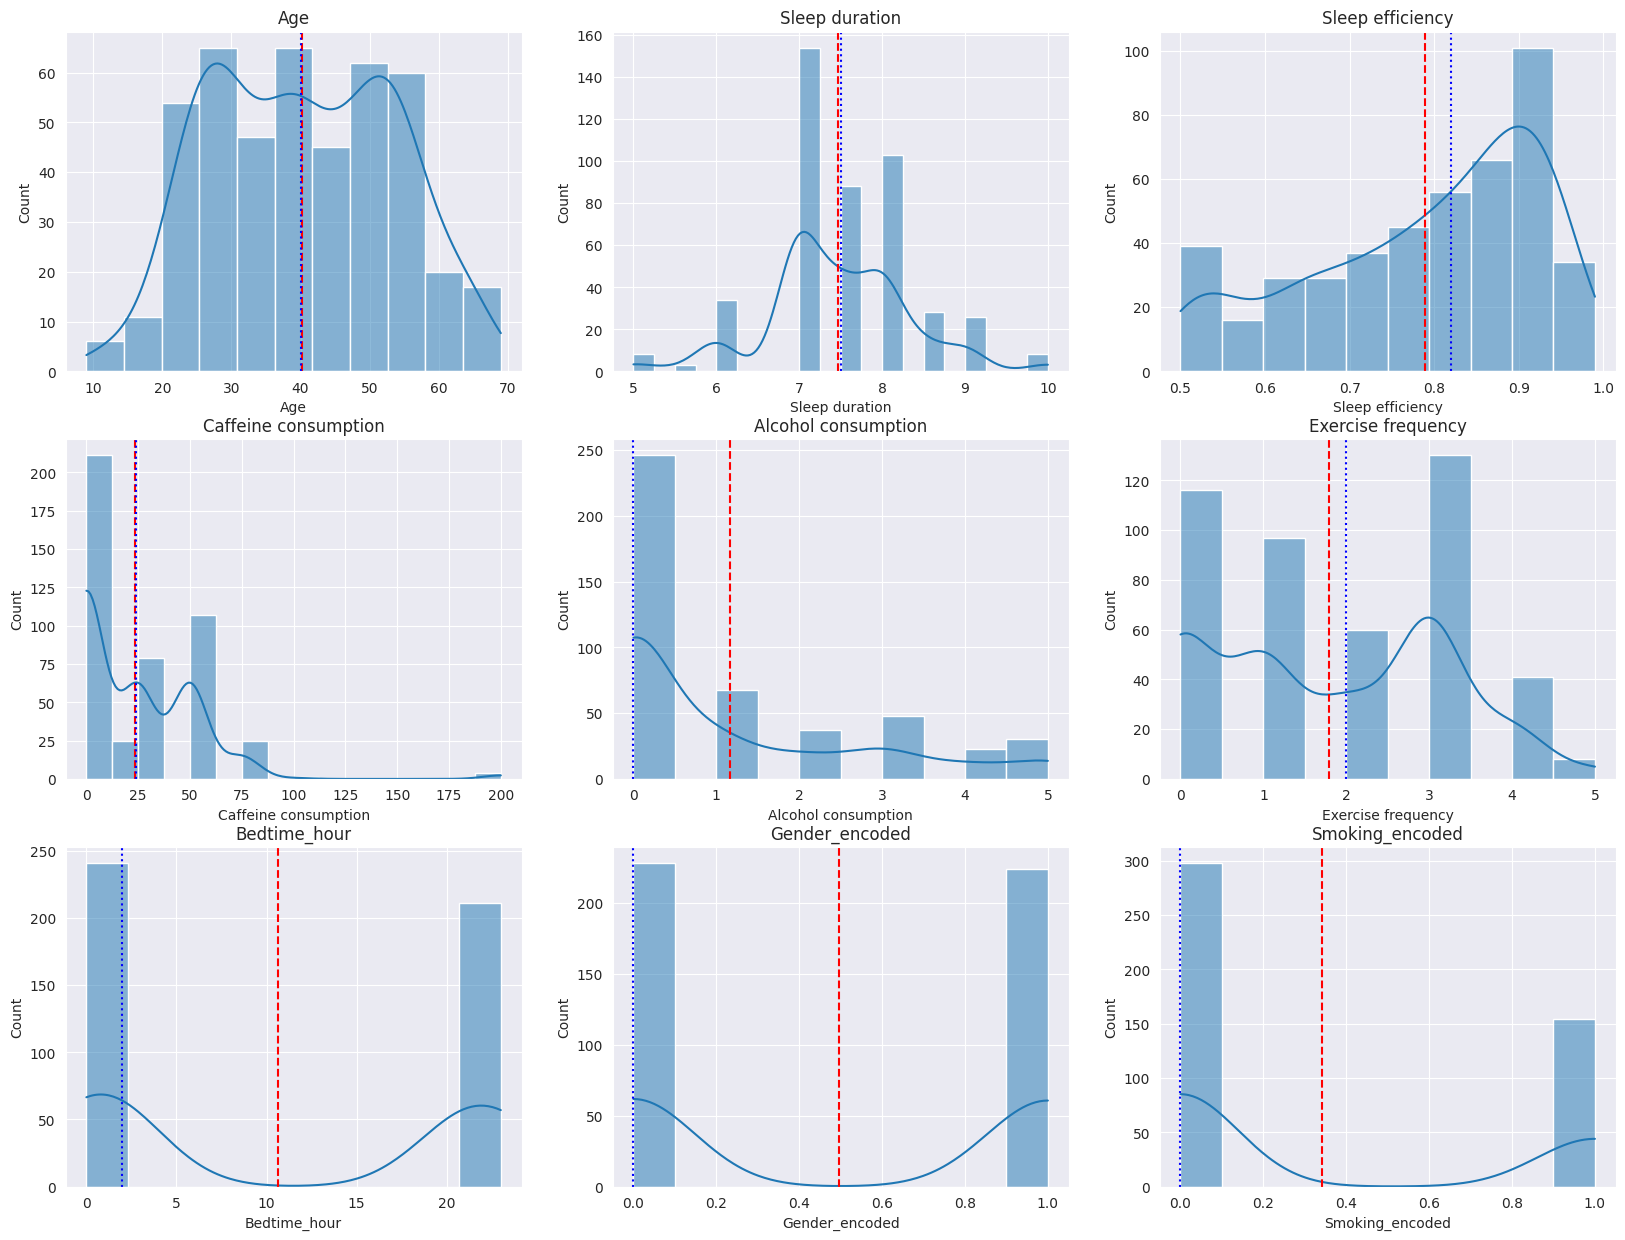

<Figure size 640x480 with 0 Axes>

In [ ]:
cols = df.columns.tolist()
cols.remove('ID')

descriptive_metrics = df[cols].describe()
descriptive_metrics.drop(axis=0, index='count', inplace=True)

sns.set_style("darkgrid")
sns.color_palette("deep")

grid_cols = 3
grid_lines = len(cols) // grid_cols if len(cols) % grid_cols == 0 else (len(cols) // grid_cols) + 1

fig, axes = plt.subplots(grid_lines, grid_cols, figsize=(20, 15) )

axes_flat = axes.flatten()
for i, col in enumerate(cols):
    axes_flat[i].set_title(col)
    sns.histplot(df[col], kde=True, ax=axes_flat[i])
    axes_flat[i].axvline(df[col].mean(), color='red', linestyle='--', label='Mean')
    axes_flat[i].axvline(df[col].median(), color='blue', linestyle=':', label='Median')

    # plt.legend()
plt.show()
plt.tight_layout()

## Teste de Normalidade

In [22]:
from scipy.stats import shapiro

stat, p = shapiro(df['Sleep efficiency'])
print(f"Shapiro-Wilk Test for Normality:")
print(f"Statistic = {stat:.4f}, p-value = {p:.4f}")

if p < 0.05:
    print("→ Reject the null hypothesis: Not enough confidence to affirm that the data is normally distributed.")
else:
    print("→ Fail to reject the null hypothesis: the data is probably normally distributed.")


Shapiro-Wilk Test for Normality:
Statistic = 0.9170, p-value = 0.0000
→ Reject the null hypothesis: Not enough confidence to affirm that the data is normally distributed.


## Hypothesis testing by groups

In [ ]:
# TODO: dividir todas as variáveis em grupos para podermos realizar testes com relação a sleep efficiency
# TODO: realizar os testes corretos para cada variável dependendo de sua natureza (categórica, discreta, ...)